# Time series measures

**This notebook investigates different Time Series measures from the `PyInform` python library**

For further info check:\
https://elife-asu.github.io/PyInform/timeseries.html \
https://github.com/ELIFE-ASU/PyInform

## Work plan

* Load data sets
* Filter frequencies using Thomas code
* On each filtered frequencies, compute entropy measures
* Plot evolution of entropy for each patient, segment per segment

In [1]:
from pyinform import active_info
from pyinform import block_entropy
from pyinform import entropy_rate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

## Load the datasets and build dataframe

In [30]:
folder_path = '/Users/commander/code/jhupiterz/SafeSeizure/raw_data'
files_patient1 = []
files_patient2 = []

dirs = ['Patient_1_csv', 'Patient_2_csv']
for f in os.listdir(os.path.join(folder_path,dirs[0],'train_segments_unlabelled')):
    files_patient1.append(f)
    
for f in os.listdir(os.path.join(folder_path,dirs[1],'train_segments_unlabelled')):
    files_patient2.append(f)

In [31]:
# Function to sort file names alphanumerically
import re
def sorted_nicely(l):
    """ Sorts the given iterable in the way that is expected.
    Required arguments:
    l -- The iterable to be sorted.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [32]:
files_patient1 = sorted_nicely(files_patient1)
files_patient2 = sorted_nicely(files_patient2)

## Block entropy for one segment

In [32]:
pwd

'/Users/commander/code/jhupiterz/SafeSeizure/notebooks'

In [36]:
data = pd.read_csv(f'../raw_data/Patient_1_csv/train_segments_unlabelled/{files_patient1[1]}')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,120.453374,101.400495,128.073670,139.141289,114.514756,98.943671,109.070968,167.602418,184.163436,168.715543,...,84.383991,72.246132,29.515626,-5.620126,9.347946,25.320824,28.446980,25.000036,21.194445,31.203993
1,627.251102,641.139677,642.875271,679.432230,643.694310,626.766145,644.249273,626.840305,644.909169,649.840612,...,-395.227706,-403.992278,-425.207954,-429.932438,-406.652165,-405.630402,-411.911799,-429.988016,-427.082703,-395.833510
2,349.375762,349.155405,320.852694,369.790533,423.457623,421.356774,399.174260,404.694632,405.279514,354.135260,...,-52.212833,-42.176564,-34.948386,-30.738140,-33.290511,-43.790662,-51.219969,-38.011046,-36.089522,-44.731316
3,341.171823,350.408281,334.211076,399.406485,480.951473,460.911593,417.770120,409.581657,387.050500,371.113191,...,-319.739182,-322.578094,-319.691703,-300.955771,-297.771555,-297.410306,-312.514791,-320.493012,-315.695234,-320.990494
4,290.569512,323.353780,342.493503,449.179735,517.841869,501.481040,469.122750,400.588491,347.210403,393.125979,...,-345.551317,-367.239174,-364.399244,-342.620273,-366.722652,-341.423016,-341.673764,-350.653533,-333.612265,-356.894372


In [37]:
data.shape

(15, 30000)

In [38]:
segment1_entropies = []
for index, row in data.iterrows():
    electrode = row
    electrode_pos = electrode + abs(electrode.min())
    entropy = block_entropy(electrode_pos.to_numpy(), k=1)
    segment1_entropies.append(entropy)
    
print(segment1_entropies)

[8.768330439469766, 10.113542282030732, 9.846956708944596, 10.33622879861844, 9.984350873510055, 9.903151966506341, 9.401975174313165, 9.748693241654935, 9.96882438052724, 9.333275136284415, 10.702413037375822, 10.069001398837885, 9.88153579449849, 10.852029543113664, 10.279807235418607]


## Block entropy for all segments in Patient 1

In [55]:
patient_entropies = []
for f in files_patient1[1:]:
    segment_entropies = []
    data = pd.read_csv(f'../raw_data/Patient_1_csv/train_segments_unlabelled/{f}')
    for index, row in data.iterrows():
        electrode = row
        electrode_pos = electrode + abs(electrode.min())
        entropy = block_entropy(electrode_pos.to_numpy(), k=1)
        segment_entropies.append(entropy)
    patient_entropies.append(segment_entropies)

In [61]:
patient1_entropies_df = pd.DataFrame.from_records(patient_entropies).T
patient1_entropies_df

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,8.768330,8.903095,8.431271,8.530645,9.469924,8.133852,9.011678,9.142487,8.913222,8.959715,...,8.179312,8.075301,8.238772,8.136665,8.759470,9.558711,8.915930,8.660512,8.671750,9.161421
1,10.113542,9.901701,10.136347,9.993158,9.926944,8.647586,9.626205,9.550565,9.665467,9.800638,...,8.997160,8.832980,8.837116,8.839680,9.495789,9.755279,9.524151,9.778313,9.604778,9.390465
2,9.846957,9.535899,9.549155,9.753571,10.489131,8.997707,8.793269,8.084306,8.045507,7.918294,...,9.750243,8.400041,8.480691,8.685473,8.906090,9.512508,9.269580,8.637838,8.834324,9.335207
3,10.336229,10.894256,11.215504,11.553188,10.917888,8.511149,10.148096,9.826793,9.457200,9.512232,...,9.352202,9.368981,9.808125,9.331075,9.416658,11.019609,10.568578,10.545505,10.469634,10.462168
4,9.984351,10.497752,10.540256,10.360874,9.997214,8.237846,9.237703,9.190806,8.621084,9.035303,...,9.576189,9.353593,9.442764,9.401006,8.897959,10.363019,9.944500,10.344455,10.162577,9.256510
5,9.903152,10.034763,9.591462,9.885109,10.802702,9.098589,9.391413,9.488707,8.408812,8.437708,...,11.262707,10.545986,10.771265,10.561510,9.122623,10.567843,10.536284,10.118343,10.586871,9.740158
6,9.401975,10.185318,10.993221,9.613061,9.481116,9.072166,9.725370,9.061184,9.211674,9.080393,...,10.557626,10.816501,11.020466,10.981431,10.011888,10.393383,10.603969,9.869606,10.061498,10.489338
7,9.748693,9.305042,9.746075,9.449139,10.252760,8.425669,8.330306,8.018345,8.042653,8.189022,...,8.889359,9.881252,9.743556,9.182370,8.546535,10.543117,10.102621,8.979847,8.523010,8.911160
8,9.968824,10.696111,9.852180,9.995103,10.024851,9.311575,8.576529,8.587834,8.297706,8.375027,...,9.201104,8.918069,8.976553,8.892925,8.562884,8.964038,8.847411,9.101740,8.892319,8.970851
9,9.333275,8.610288,9.184827,9.115094,9.947878,8.231424,9.436015,8.063803,8.125873,8.012288,...,9.414062,9.264628,9.569534,9.232966,8.830679,9.728120,10.314534,9.585944,9.161162,9.275708


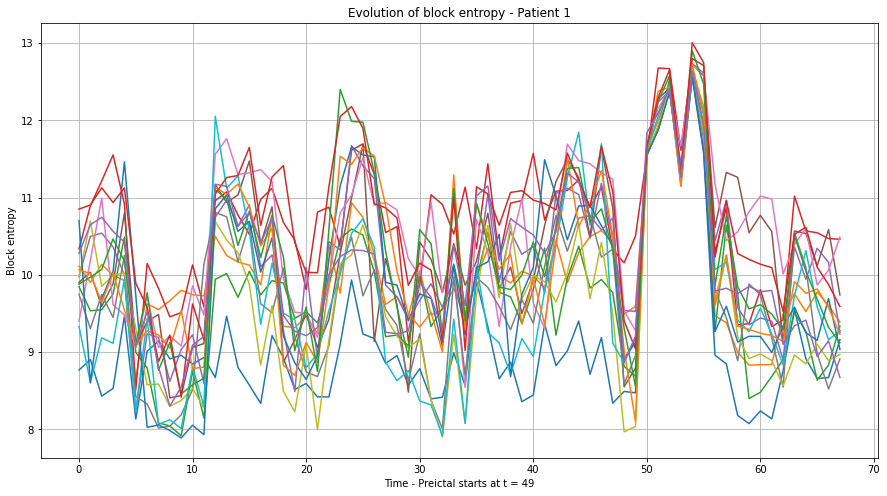

In [68]:
plt.figure(figsize=(15,8))
for index, row in patient1_entropies_df.iterrows():
    plt.plot(row)
plt.title('Evolution of block entropy - Patient 1')
plt.grid()
plt.xlabel('Time - Preictal starts at t = 49')
plt.ylabel('Block entropy');

## Block entropy for all segments in Patient 2

In [72]:
patient_entropies = []
for f in files_patient2:
    segment_entropies = []
    data = pd.read_csv(f'../raw_data/Patient_2_csv/train_segments_unlabelled/{f}')
    for index, row in data.iterrows():
        electrode = row
        electrode_pos = electrode + abs(electrode.min())
        entropy = block_entropy(electrode_pos.to_numpy(), k=1)
        segment_entropies.append(entropy)
    patient_entropies.append(segment_entropies)

In [73]:
patient2_entropies_df = pd.DataFrame.from_records(patient_entropies).T
patient2_entropies_df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,9.075858,9.146555,9.167696,8.730623,9.131366,8.917393,9.341817,9.402221,9.111258,9.173565,...,9.708572,9.391014,9.510786,8.818055,9.906909,9.834306,9.235893,9.524114,9.771514,9.697823
1,9.273952,9.382197,9.385198,9.169931,9.311179,8.982167,9.492480,9.500203,9.272389,9.399492,...,9.724090,9.478976,9.547622,9.382884,9.983217,9.894649,9.372021,9.660563,9.825016,9.795816
2,9.509077,9.510474,9.484948,9.411834,9.408040,9.205612,9.598645,9.610999,9.523059,9.508993,...,9.726209,9.420166,9.497902,9.516566,9.908339,9.830385,9.327988,9.589117,9.717020,9.749743
3,8.551848,8.494599,8.465523,8.586054,9.006088,8.737529,8.774035,8.948120,8.625383,8.511651,...,9.125405,8.337890,8.705313,8.610983,9.599594,9.507286,8.597216,9.162107,9.406813,9.369201
4,8.251576,8.217792,8.165429,8.423695,8.818296,8.524451,8.605705,8.785344,8.369773,8.221761,...,9.022807,8.162865,8.532659,8.479959,9.532338,9.402680,8.360947,9.047600,9.357707,9.259680
5,7.943774,7.866673,7.792876,8.186496,8.548825,8.277920,8.403256,8.623527,8.126663,7.908750,...,8.916312,7.972434,8.386410,8.298400,9.465429,9.324827,8.178538,8.962762,9.274856,9.185832
6,7.798993,7.676863,7.575715,8.040408,8.341666,8.149329,8.232864,8.510885,7.980702,7.732432,...,8.812443,7.838740,8.279331,8.193511,9.448621,9.317106,8.120369,8.926496,9.271952,9.167300
7,7.599758,7.411202,7.336453,7.884493,8.161376,7.989212,8.068881,8.386903,7.794851,7.493773,...,8.673579,7.671944,8.164031,8.050561,9.415090,9.285512,8.001509,8.895349,9.236968,9.112400
8,8.994653,9.126566,9.076514,8.518083,9.023290,8.698545,9.193079,9.170446,8.997098,9.135234,...,9.187627,8.561584,9.114648,8.444014,9.779462,9.748261,9.236873,9.471128,9.688815,9.658797
9,8.854068,8.960314,8.967707,8.796966,9.196306,8.815404,9.087206,9.161395,8.880927,8.981904,...,9.275636,8.754674,9.099169,8.582995,9.743918,9.672458,9.019164,9.333018,9.576842,9.525119


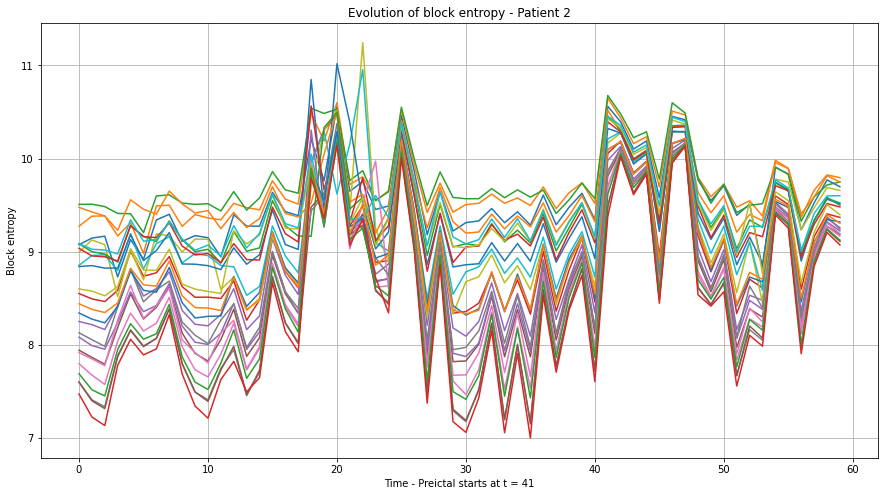

In [75]:
plt.figure(figsize=(15,8))
for index, row in patient2_entropies_df.iterrows():
    plt.plot(row)
plt.title('Evolution of block entropy - Patient 2')
plt.grid()
plt.xlabel('Time - Preictal starts at t = 41')
plt.ylabel('Block entropy');